In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import sqrtm
from sklearn.linear_model import ElasticNet
from saddle_point.experiments.learning_curve import LearningCurve

In [2]:
def get_meancov(dimension=500, *, rho,delta0,delta1):
    mean = np.random.normal(0, 1, dimension) / np.sqrt(dimension)
    idx = np.random.choice(dimension, size=int((1-rho)*dimension), replace=False)
    cov = delta1 * np.identity(dimension)
    sqrtcov = np.sqrt(delta1) * np.identity(dimension)
    cov[idx, idx] = delta0
    sqrtcov[idx, idx] = np.sqrt(delta0)
    mean[idx] = 0.
    return mean, cov, sqrtcov

In [3]:
d = 500
lamb = 0.1
rho = 0.5
delta0 = 0.1
delta1 = 0.5
prob = 0.5

## Simulations

In [7]:
def get_samples(*, n, mean, sqrtcov, prob):
    y = np.random.choice([1,-1], n, p = [prob, 1-prob])
    X = y.reshape(n,1) @ mean.reshape(1,d) + np.random.normal(0,1,(n,d)) @ sqrtcov.T
    return X/np.sqrt(d), y

In [8]:
def get_errors(*, samples, prob, lamb, seeds, delta0,delta1, rho, penalty):
    '''
    Get averaged training and test error over a number of seeds for a fixed 
    number of samples.
    '''
    
    eg, et, q_tab, m_tab, b_tab = [], [], [], [], []
    
    for i in range(seeds):
       # print('Seed: {}'.format(i))
        
        mean, cov, sqrtcov = get_meancov(dimension=d, 
              rho=rho, 
              delta0=delta0, 
              delta1=delta1)

        # Randomly subsample a set of indices (without replacement)
        X_train, y_train = get_samples(n=samples, 
                                       sqrtcov=sqrtcov, 
                                       mean=mean,
                                       prob=prob)
        
        X_test, y_test = get_samples(n=1000, 
                                     sqrtcov=sqrtcov, 
                                     mean=mean,
                                     prob=prob)


        l1_ratio = (1e-10 if penalty == 'l2' else 1-1e-10)
            
        clf = ElasticNet(alpha = lamb / samples, 
                   l1_ratio = l1_ratio,
                   fit_intercept=True, 
                   tol=1e-8, 
                   max_iter=1e8).fit(X_train, y_train)

        w, b = clf.coef_, clf.intercept_
            
        # Label estimate
        yhat_train = (X_train @ w + b)
        yhat_test = np.sign(X_test @ w + b)

        # Errors
        test_error = .25 * np.mean((yhat_test-y_test)**2)
        train_loss = .5 * np.mean((yhat_train-y_train)**2)
        
        q = w.dot(cov @ w) / d        
        m = mean.dot(w) / np.sqrt(d)
                
        eg.append(test_error)
        et.append(train_loss)
        
        q_tab.append(q)
        m_tab.append(m)
        b_tab.append(b)

    return (np.mean(et), np.std(et), np.mean(eg), np.std(eg),
            np.mean(q_tab), np.std(q_tab), 
            np.mean(m_tab), np.std(m_tab),
            np.mean(b_tab), np.std(b_tab)
           )

In [9]:
def simulate(seeds=10, prob=.5, penalty='l1', *, sc_range, lamb, delta0,delta1,rho):

    data = {'test_error': [], 'train_loss': [], 'test_error_std': [], 
            'train_loss_std': [], 'lambda': [], 'probability': [],
            'sample_complexity': [], 'samples': [], 'rho': [], 'penalty': [],
            'q': [], 'q_std': [], 'm': [], 'm_std': [], 'b': [], 'b_std': []}
    
    for alpha in sc_range:
        print('Simulating sample complexity: {}'.format(alpha))
        samples = int(alpha * d)
        et, et_std, eg, eg_std, q, q_std, m, m_std, b, b_std = get_errors(samples=samples, 
                                                                prob=prob, 
                                                                lamb=lamb, 
                                                                seeds=seeds, 
                                                                delta0=delta0,delta1=delta1,
                                                                rho=rho,
                                                                penalty=penalty)
        
        data['sample_complexity'].append(alpha)
        data['samples'].append(samples)
        data['probability'].append(prob)
        data['rho'].append(rho)
        data['penalty'].append(penalty)
        
        data['lambda'].append(lamb)

        data['test_error'].append(eg)
        data['test_error_std'].append(eg_std)
        data['train_loss'].append(et)
        data['train_loss_std'].append(et_std)

        data['q'].append(q)
        data['q_std'].append(q_std)

        data['m'].append(m)
        data['m_std'].append(m_std)

        data['b'].append(b)
        data['b_std'].append(b_std)
        
    return pd.DataFrame.from_dict(data)

In [10]:
sc_range = np.linspace(0.1, 3, 10)
l1 = simulate(sc_range=sc_range, 
                lamb=lamb, 
                delta0=0.1,delta1=0.5,
                rho=rho,
                penalty='l1',
                seeds=10)
l1bis = simulate(sc_range=sc_range, 
                lamb=lamb, 
                delta0=0.5,delta1=0.1,
                rho=rho,
                penalty='l1',
                seeds=10)
l2 = simulate(sc_range=sc_range, 
                lamb=lamb, 
                delta0=0.1,delta1=0.5,
                rho=rho,
                penalty='l2',
                seeds=10)
l2bis = simulate(sc_range=sc_range, 
                lamb=lamb, 
                delta0=0.5,delta1=0.1,
                rho=rho,
                penalty='l2',
                seeds=10)

Simulating sample complexity: 0.1
Simulating sample complexity: 0.42222222222222217
Simulating sample complexity: 0.7444444444444444
Simulating sample complexity: 1.0666666666666667
Simulating sample complexity: 1.3888888888888888
Simulating sample complexity: 1.711111111111111
Simulating sample complexity: 2.033333333333333
Simulating sample complexity: 2.3555555555555556
Simulating sample complexity: 2.6777777777777776
Simulating sample complexity: 3.0
Simulating sample complexity: 0.1
Simulating sample complexity: 0.42222222222222217
Simulating sample complexity: 0.7444444444444444
Simulating sample complexity: 1.0666666666666667
Simulating sample complexity: 1.3888888888888888
Simulating sample complexity: 1.711111111111111
Simulating sample complexity: 2.033333333333333
Simulating sample complexity: 2.3555555555555556
Simulating sample complexity: 2.6777777777777776
Simulating sample complexity: 3.0
Simulating sample complexity: 0.1
Simulating sample complexity: 0.4222222222222221

In [4]:
experimentl1 = LearningCurve(loss = 'square', 
                            problem = 'sparse',
                            penalty = 'l1',
                            regularisation = lamb, 
                            variances = [delta0, delta1], 
                            ratios = rho,
                            probability = prob,
                            damping=0.9)
experimentl1.learning_curve(sc_range = np.linspace(0.1, 3, 30))
experimentl1bis = LearningCurve(loss = 'square', 
                            problem = 'sparse',
                            penalty = 'l1', 
                            regularisation = lamb, 
                            variances = [delta1, delta0], 
                            ratios = rho,
                            probability = prob,
                            damping=0.9)
experimentl1bis.learning_curve(sc_range = np.linspace(0.01, 3, 30))
experimentl2 = LearningCurve(loss = 'square', 
                            problem = 'sparse',
                            penalty = 'l2',
                            regularisation = lamb, 
                            variances = [delta0, delta1], 
                            ratios = rho,
                            probability = prob,
                            damping=0.9)
experimentl2.learning_curve(sc_range = np.linspace(0.1, 3, 30))
experimentl2bis = LearningCurve(loss = 'square', 
                            problem = 'sparse',
                            penalty = 'l2', 
                            regularisation = lamb, 
                            variances = [delta1, delta0], 
                            ratios = rho,
                            probability = prob,
                            damping=0.9)
experimentl2bis.learning_curve(sc_range = np.linspace(0.01, 3, 30))

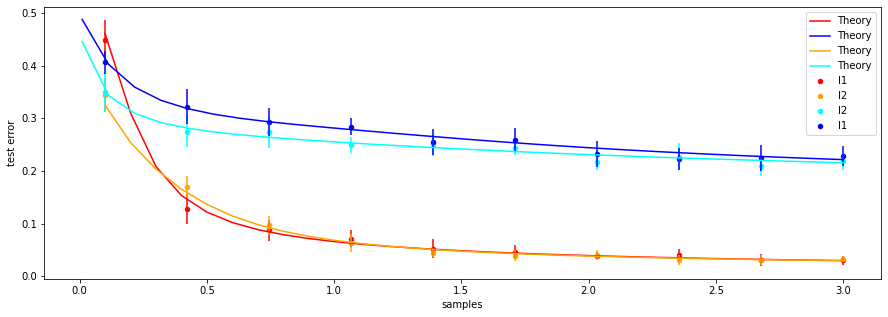

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
ax=experimentl1.get_curve().plot(x='sample_complexity', 
        y='test_error', 
        #kind = 'scatter',
        ax=ax, color='red',
        label='Theory')
ax=experimentl1bis.get_curve().plot(x='sample_complexity', 
        y='test_error', 
        #kind = 'scatter',
        ax=ax, color='blue',
        label='Theory')
ax=experimentl2.get_curve().plot(x='sample_complexity', 
        y='test_error', 
        #kind = 'scatter',
        ax=ax, color='orange',
        label='Theory')
ax=experimentl2bis.get_curve().plot(x='sample_complexity', 
        y='test_error', 
        #kind = 'scatter',
        ax=ax, color='cyan',
        label='Theory')
ax=l1bis.plot(x='sample_complexity', 
        y='test_error', 
        kind = 'scatter',
        yerr='test_error_std',
        ax=ax, color='red',
        label='l1')
ax=l2bis.plot(x='sample_complexity', 
        y='test_error', 
        kind = 'scatter',
        yerr='test_error_std',
        ax=ax, color='orange',
        label='l2')
ax=l2.plot(x='sample_complexity', 
        y='test_error', 
        kind = 'scatter',
        yerr='test_error_std',
        ax=ax, color='cyan',
        label='l2')
l1.plot(x='sample_complexity', 
        y='test_error', 
        kind = 'scatter',
        yerr='test_error_std',
        ax=ax, color='blue',
        label='l1')

plt.ylabel(r"test error")
plt.xlabel(r"samples")

plt.legend()
#plt.savefig('../figs/ridge_teacher=sign_student=erf_lambda=0.1.pdf', bbox_inches='tight')

Single check

In [ ]:
sc_range = np.linspace(0.1, 3, 10)
l0 = simulate(sc_range=sc_range, 
                lamb=0.1, 
                delta0=1,delta1=2,
                rho=0.8,
                penalty='l1',
                seeds=50)

In [ ]:
experiment0 = LearningCurve(loss = 'square', 
                            problem = 'sparse',
                            penalty = 'l2',
                            regularisation = 0.1, 
                            variances = [1,2], 
                            ratios = 0.8,
                            probability = 0.5,
                            damping=0.9)
experiment0.learning_curve(sc_range = np.linspace(0.1, 3, 30))

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax0=experiment0.get_curve().plot(x='sample_complexity', 
        y='test_error', 
        #kind = 'scatter',
        ax=ax, color='blue',
        label='Theory')
l0.plot(x='sample_complexity', 
        y='test_error', 
        kind = 'scatter',
        yerr='test_error_std',
        ax=ax, color='blue',
        label='l1')

plt.ylabel(r"test error")
plt.xlabel(r"samples")

plt.legend()
#plt.savefig('../figs/ridge_teacher=sign_student=erf_lambda=0.1.pdf', bbox_inches='tight')